In [1]:
import torch
from torch import nn
import timm
from timm.data import resolve_data_config, create_transform

from PIL import Image
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
device = (
    "cuda:0"
    if torch.cuda.is_available()
    else ("mps" if torch.backends.mps.is_available() else "cpu")
)
device = "cpu"  # 11G显存不够用,所以用cpu

# models

In [3]:
timm.list_models(["*sam*"], pretrained=True)

['samvit_base_patch16.sa1b',
 'samvit_huge_patch16.sa1b',
 'samvit_large_patch16.sa1b',
 'vit_base_patch16_224.sam_in1k',
 'vit_base_patch32_224.sam_in1k']

In [4]:
model = timm.create_model(
    "samvit_base_patch16.sa1b", pretrained=True, num_classes=0
).to(device)
model.eval()

VisionTransformerSAM(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identi

In [5]:
data_config = resolve_data_config({}, model=model)
data_config

{'input_size': (3, 1024, 1024),
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'crop_pct': 1.0,
 'crop_mode': 'center'}

In [6]:
transform = create_transform(**data_config)
transform

Compose(
    Resize(size=1024, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(1024, 1024))
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

# images

In [7]:
image_dict = {}
for i in glob("*.jpg"):
    image_dict[i.split(".")[0]] = Image.open(i)
list(image_dict.keys())

['cat1',
 'cat2',
 'cat3',
 'cat4',
 'cat5',
 'dog1',
 'dog2',
 'dog3',
 'dog4',
 'dog5']

In [8]:
image_dict[list(image_dict.keys())[0]].size

(1280, 1280)

In [9]:
def preprocess(image_dict: dict) -> dict:
    procss_images = {}
    for k, v in image_dict.items():
        procss_images[k] = transform(v)
    return procss_images

In [10]:
procss_images = preprocess(image_dict)
procss_images[list(procss_images.keys())[0]].shape

torch.Size([3, 1024, 1024])

# run

In [11]:
with torch.inference_mode():
    extracts = model(torch.stack(list(procss_images.values()), dim=0).to(device))
extracts.shape

torch.Size([10, 256])

In [12]:
temp = extracts[:1]
temp.shape

torch.Size([1, 256])

In [13]:
# l2norm
temp.norm(p=2, dim=-1), temp.square().sum().sqrt()

(tensor([2.0868]), tensor(2.0868))

In [14]:
# l1norm
temp.norm(p=1, dim=-1), temp.abs().sum()

(tensor([19.2733]), tensor(19.2733))

# cosine similarity


[cosine similarity 详细介绍](../01_PyTorch基本/05数学运算/cosine%20similarity.ipynb)

In [15]:
cos_similarity_t = (extracts / extracts.norm(p=2, dim=1, keepdim=True)) @ (
    extracts / extracts.norm(p=2, dim=1, keepdim=True)
).T
cos_similarity_t

tensor([[1.0000, 0.9877, 0.9930, 0.9960, 0.9548, 0.9775, 0.9784, 0.9936, 0.9930,
         0.9903],
        [0.9877, 1.0000, 0.9890, 0.9805, 0.9396, 0.9739, 0.9762, 0.9843, 0.9763,
         0.9840],
        [0.9930, 0.9890, 1.0000, 0.9902, 0.9420, 0.9640, 0.9656, 0.9809, 0.9922,
         0.9921],
        [0.9960, 0.9805, 0.9902, 1.0000, 0.9454, 0.9690, 0.9729, 0.9882, 0.9954,
         0.9892],
        [0.9548, 0.9396, 0.9420, 0.9454, 1.0000, 0.9477, 0.9599, 0.9663, 0.9482,
         0.9368],
        [0.9775, 0.9739, 0.9640, 0.9690, 0.9477, 1.0000, 0.9659, 0.9817, 0.9643,
         0.9687],
        [0.9784, 0.9762, 0.9656, 0.9729, 0.9599, 0.9659, 1.0000, 0.9866, 0.9648,
         0.9670],
        [0.9936, 0.9843, 0.9809, 0.9882, 0.9663, 0.9817, 0.9866, 1.0000, 0.9831,
         0.9821],
        [0.9930, 0.9763, 0.9922, 0.9954, 0.9482, 0.9643, 0.9648, 0.9831, 1.0000,
         0.9898],
        [0.9903, 0.9840, 0.9921, 0.9892, 0.9368, 0.9687, 0.9670, 0.9821, 0.9898,
         1.0000]])

In [16]:
cos_similarity = cos_similarity_t.cpu().detach().numpy()

In [17]:
names = list(procss_images.keys())
names

['cat1',
 'cat2',
 'cat3',
 'cat4',
 'cat5',
 'dog1',
 'dog2',
 'dog3',
 'dog4',
 'dog5']

In [18]:
figure = px.imshow(
    cos_similarity,
    text_auto=True,
    x=names,
    y=names,
    width=800,
    height=800,
    title="cat, dog cos similarity",
)
figure.show()

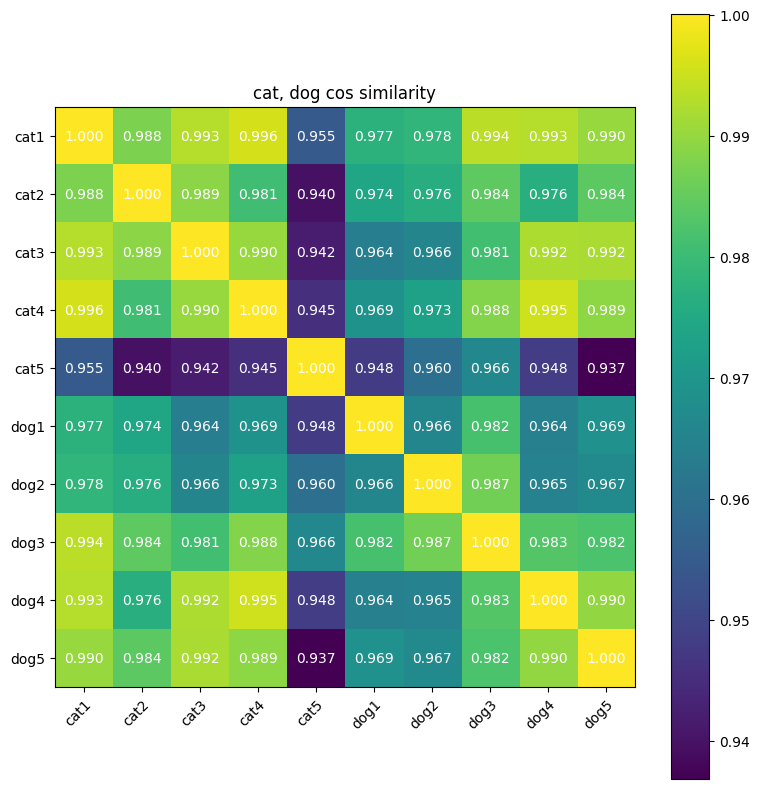

In [19]:
plt.figure(figsize=(8, 8))
plt.xticks(
    np.arange(len(names)), labels=names, rotation=45, rotation_mode="anchor", ha="right"
)
plt.yticks(np.arange(len(names)), labels=names)
plt.title("cat, dog cos similarity")

# 绘图
plt.imshow(cos_similarity)

# 添加文字
for i in range(len(names)):
    for j in range(len(names)):
        text = plt.text(
            j,
            i,
            "{:.3f}".format(cos_similarity[i, j]),
            ha="center",
            va="center",
            color="w",
        )

plt.colorbar()  # 右侧的条
plt.tight_layout()
plt.show()